# Metric Learning - Additive Angular Margin Loss (ArcFace)

### Imports

In [1]:
from pathlib import Path
import numpy as np
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten
from keras.regularizers import l2
from sklearn.manifold import TSNE
import time
from time import process_time
import random
from sklearn import decomposition, datasets, discriminant_analysis
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score

tf.config.optimizer.set_jit(False)

### Load dataset

This will work straight out of the box if you [download the dataset from kaggle](https://www.kaggle.com/datasets/gpiosenka/100-bird-species/data) directly into our root directory, and leave the file names as is.
#### It should find (reduced dataset to 100 classes):
- Train set: 15760 files belonging to 100 classes.
- Test set: 500 files belonging to 100 classes. 
- Validation set: 500 files belonging to 100 classes.

In [2]:
ROOT_DIR = Path('./archive')
TRAIN_DIR = ROOT_DIR.joinpath('train')
VALID_DIR = ROOT_DIR.joinpath('valid')
TEST_DIR = ROOT_DIR.joinpath('test')


# Function to get the first 100 class names
def get_first_n_classes(directory, n=100):
    all_classes = sorted([item.name for item in directory.glob('*') if item.is_dir()])
    return all_classes[:n]

# Get the first 100 class names
first_100_classes = get_first_n_classes(TRAIN_DIR)

# Load the filtered training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(96, 96),
    batch_size=None,
    label_mode='categorical',
    shuffle=True,
    class_names=first_100_classes   # Filtering first 100 classes
)

#Load the validation dataset
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VALID_DIR,
    image_size=(96, 96),
    batch_size=None,
    label_mode='categorical',
    shuffle = False,
    class_names=first_100_classes  
)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=(96, 96),
    batch_size=None,
    label_mode='categorical',
    shuffle = False,
    class_names=first_100_classes
)

# Print some information about the datasets
print(f"Training dataset: {train_dataset.cardinality().numpy()} batches")
print(f"Validation dataset: {valid_dataset.cardinality().numpy()} batches")
print(f"Test dataset: {test_dataset.cardinality().numpy()} batches")

# Inspect the class names
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Found 15760 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Training dataset: 15760 batches
Validation dataset: 500 batches
Test dataset: 500 batches
Class names: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRES

In [3]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.float32, name=None))>

In [4]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in valid_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in test_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(96, 96, 3)
(100,)
(96, 96, 3)
(100,)
(96, 96, 3)
(100,)


In [3]:
batch_size = 246
AUTOTUNE = tf.data.AUTOTUNE

# Rescaling operation. No resizing here as we already have small images (96x96)
rescale = keras.Sequential([
    layers.Rescaling(1./255)
])

# Augmentation operations
augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.4),
])

# Function to apply rescaling and augmentation (if wanted)
def prepare_ds(ds, augment=False):
    
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only if requested
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        
    ds = ds.map(lambda x, y: ((x, tf.cast(y, tf.int64)), tf.cast(y, tf.int64)))
    
    return ds

# Function to apply batching and prefetching
def batch_and_prefetch(ds):       
    # Batch the dataset
    ds = ds.batch(batch_size)
    
    # Use buffered prefetching
    return ds.prefetch(buffer_size=AUTOTUNE)

# Use augmentation for training data only
ds_train = prepare_ds(train_dataset, True)
ds_valid = prepare_ds(train_dataset, True)
ds_test = prepare_ds(test_dataset, False)

# Batch and prefetch datasets
ds_train = batch_and_prefetch(ds_train)
ds_valid = batch_and_prefetch(ds_valid)
ds_test = batch_and_prefetch(ds_test)

In [4]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):

    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [5]:
class ArcFace(keras.Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = None

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)
        print(self.W)

    def call(self, inputs, training=None):
        x, y = inputs
        c = keras.ops.shape(x)[-1]
        # normalize feature
        x = keras.utils.normalize(x, order=2, axis=1)
        # normalize weights
        W = keras.utils.normalize(self.W, order=2, axis=0)
        # dot product
        logits = keras.ops.matmul(x, W)
        
        # add margin
        # clip logits to prevent zero division when backward
        theta = keras.ops.arccos(keras.ops.clip(logits, -1.0 + keras.config.epsilon(), 1.0 - keras.config.epsilon()))
        target_logits = keras.ops.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = keras.ops.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

<KerasVariable shape=(128, 100), dtype=float32, path=arc_face_1/W>


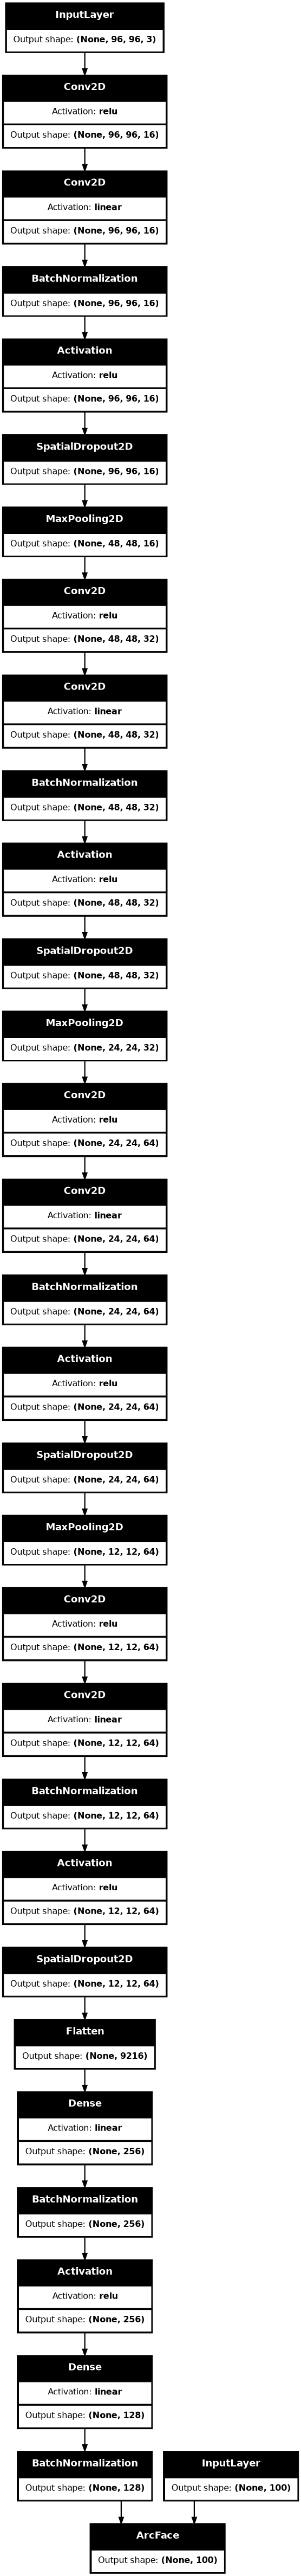

In [9]:
embedding_size = 128
dummy_input = keras.Input((96, 96, 3))
base_network = vgg_net(dummy_input, [16, 32, 64, 64], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None, name='embedding')(base_network)

label = keras.Input(shape=(100,))
embedding_layer = layers.BatchNormalization()(embedding_layer)
output = ArcFace(n_classes=100)([embedding_layer, label])
arc_network = keras.Model([dummy_input, label], output, name='arc')
keras.utils.plot_model(arc_network, show_shapes=True, dpi=80, show_layer_activations=True)

In [11]:
arc_network.summary()
arc_network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], jit_compile=False)

Model: "arc"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 96, 96,    │        448 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 96, 96,    │      2,320 │ conv2d_8[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │         64 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_4 │ (None, 96, 96,    │          0 │ activation_5[0][… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 48, 48,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 48, 48,    │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 48, 48,    │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_5 │ (None, 48, 48,    │          0 │ activation_6[0][… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 24, 24,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 24, 24,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 24, 24,    │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 24, 24,    │          0 │ batch_normalizat

 Total params: 2,553,424 (9.74 MB)

 Trainable params: 2,552,304 (9.74 MB)

 Non-trainable params: 1,120 (4.38 KB)

In [9]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)

# record training time
arc_train_start = process_time()
arc_history = arc_network.fit(ds_train, epochs=1000, verbose=True, validation_data=ds_valid, callbacks=[early_stopping_callback])
arc_train_end = process_time()

arc_train_time = arc_train_end - arc_train_start
print('Training Time (seconds) \n', arc_train_time)

Epoch 1/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 480ms/step - accuracy: 0.0000e+00 - loss: 20.1330 - val_accuracy: 0.0000e+00 - val_loss: 19.2600
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.0000e+00 - loss: 18.3839 - val_accuracy: 0.0000e+00 - val_loss: 19.3896
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 429ms/step - accuracy: 0.0000e+00 - loss: 17.8454 - val_accuracy: 0.0000e+00 - val_loss: 18.6109
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 429ms/step - accuracy: 0.0000e+00 - loss: 16.9516 - val_accuracy: 0.0000e+00 - val_loss: 16.4262
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 422ms/step - accuracy: 0.0000e+00 - loss: 15.1858 - val_accuracy: 0.0000e+00 - val_loss: 13.1304
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.0000e+00 - loss: 11.8793 - val_accuracy: 0.0000e+00 - val_loss: 8.5705
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 424ms/step - accuracy: 0.0526 - loss: 6.9906 - val_accuracy: 0.9594 - val_loss: 3.3557
Epoch 8/1000
65/65 ━━━━━

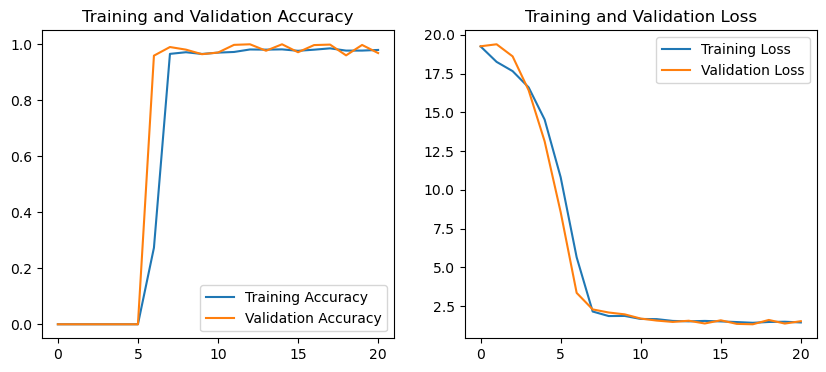

In [10]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(arc_network.history)

In [12]:
def eval_model(model, history, test_dataset, class_names):
    arc_test_time_start = process_time()
    
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_accuracy)
    
    arc_test_time_end = process_time()
    arc_inference_test_time = arc_test_time_end - arc_test_time_start
    print('Inference Time (testing set):', arc_inference_test_time)
    
    # Get true labels and predictions
    true_labels = []
    predictions = []
    
    for images, labels in test_dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        labels_indices = np.argmax(labels.numpy(), axis=1)  # Convert one-hot to indices
        true_labels.extend(labels_indices)
        predictions.extend(preds)
    
    report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)
    print(classification_report(true_labels, predictions, target_names=class_names))
    
    # Extract F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')
    print('Training - F1 score:', f1)
    
    # Plot training history
    fig = plt.figure(figsize=[8, 4])
    ax = fig.add_subplot(1, 1, 1)
    plotted = False  # Flag to track if any lines are plotted

    if 'loss' in history.history:
        ax.plot(history.history['loss'], label='Training Loss')
        plotted = True
    if 'accuracy' in history.history:
        ax.plot(history.history['accuracy'], label='Training Accuracy')
        plotted = True
    if 'val_loss' in history.history:
        ax.plot(history.history['val_loss'], label='Validation Loss')
        plotted = True
    if 'val_accuracy' in history.history:
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plotted = True

    ax.set_xlabel('Training Epochs')
    ax.set_ylabel('Accuracy or Loss')

    if plotted:
        ax.legend()  # Only call this if something was plotted

    return report

Test loss: 1.3211809396743774
Test accuracy: 1.0
Inference Time (testing set): %f 1.7410086319998754
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       1.00      1.00      1.00         5
             ABBOTTS BOOBY       1.00      1.00      1.00         5
ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
     AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
    AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
         AFRICAN FIREFINCH       1.00      1.00      1.00         5
    AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
     AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
       AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                 ALBATROSS       1.00      1.00      1.00         5
            ALBERTS TOWHEE       1.0

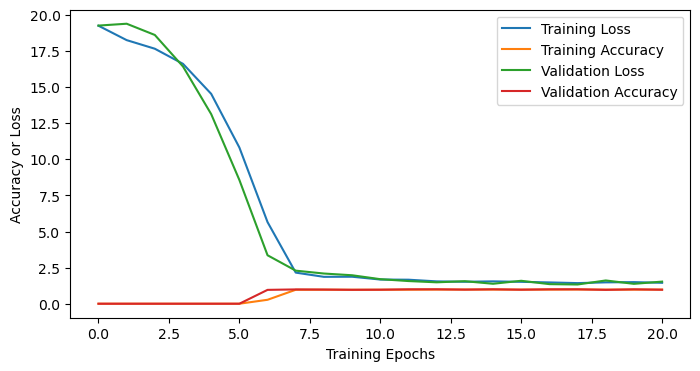

In [13]:
# Use the functions
report = eval_model(arc_network, arc_network.history, ds_test, class_names)

In [14]:
def plot_confusion_matrix(model, test_dataset, class_names, num_classes=30):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import random

    # Randomly select class indices
    selected_classes = random.sample(range(len(class_names)), num_classes)
    selected_classes.sort()  # Sort for consistent display

    # Create a mapping from old indices to new indices
    class_map = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_classes)}

    # Get true labels and predictions
    true_labels = []
    predictions = []
    for images, labels in test_dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot to indices if necessary
        true_labels.extend(labels)
        predictions.extend(preds)

    # Filter to only include the selected classes
    filtered_true_labels = []
    filtered_predictions = []
    for true_label, pred in zip(true_labels, predictions):
        if true_label in selected_classes and pred in selected_classes:
            filtered_true_labels.append(class_map[true_label])
            filtered_predictions.append(class_map[pred])

    # Compute confusion matrix for the filtered classes
    cm = confusion_matrix(filtered_true_labels, filtered_predictions, labels=range(num_classes))
    selected_class_names = [class_names[i] for i in selected_classes]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_class_names)
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    ax = plt.gca()
    disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='vertical')

    plt.title(f"Confusion Matrix for {num_classes} Random Classes")
    plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


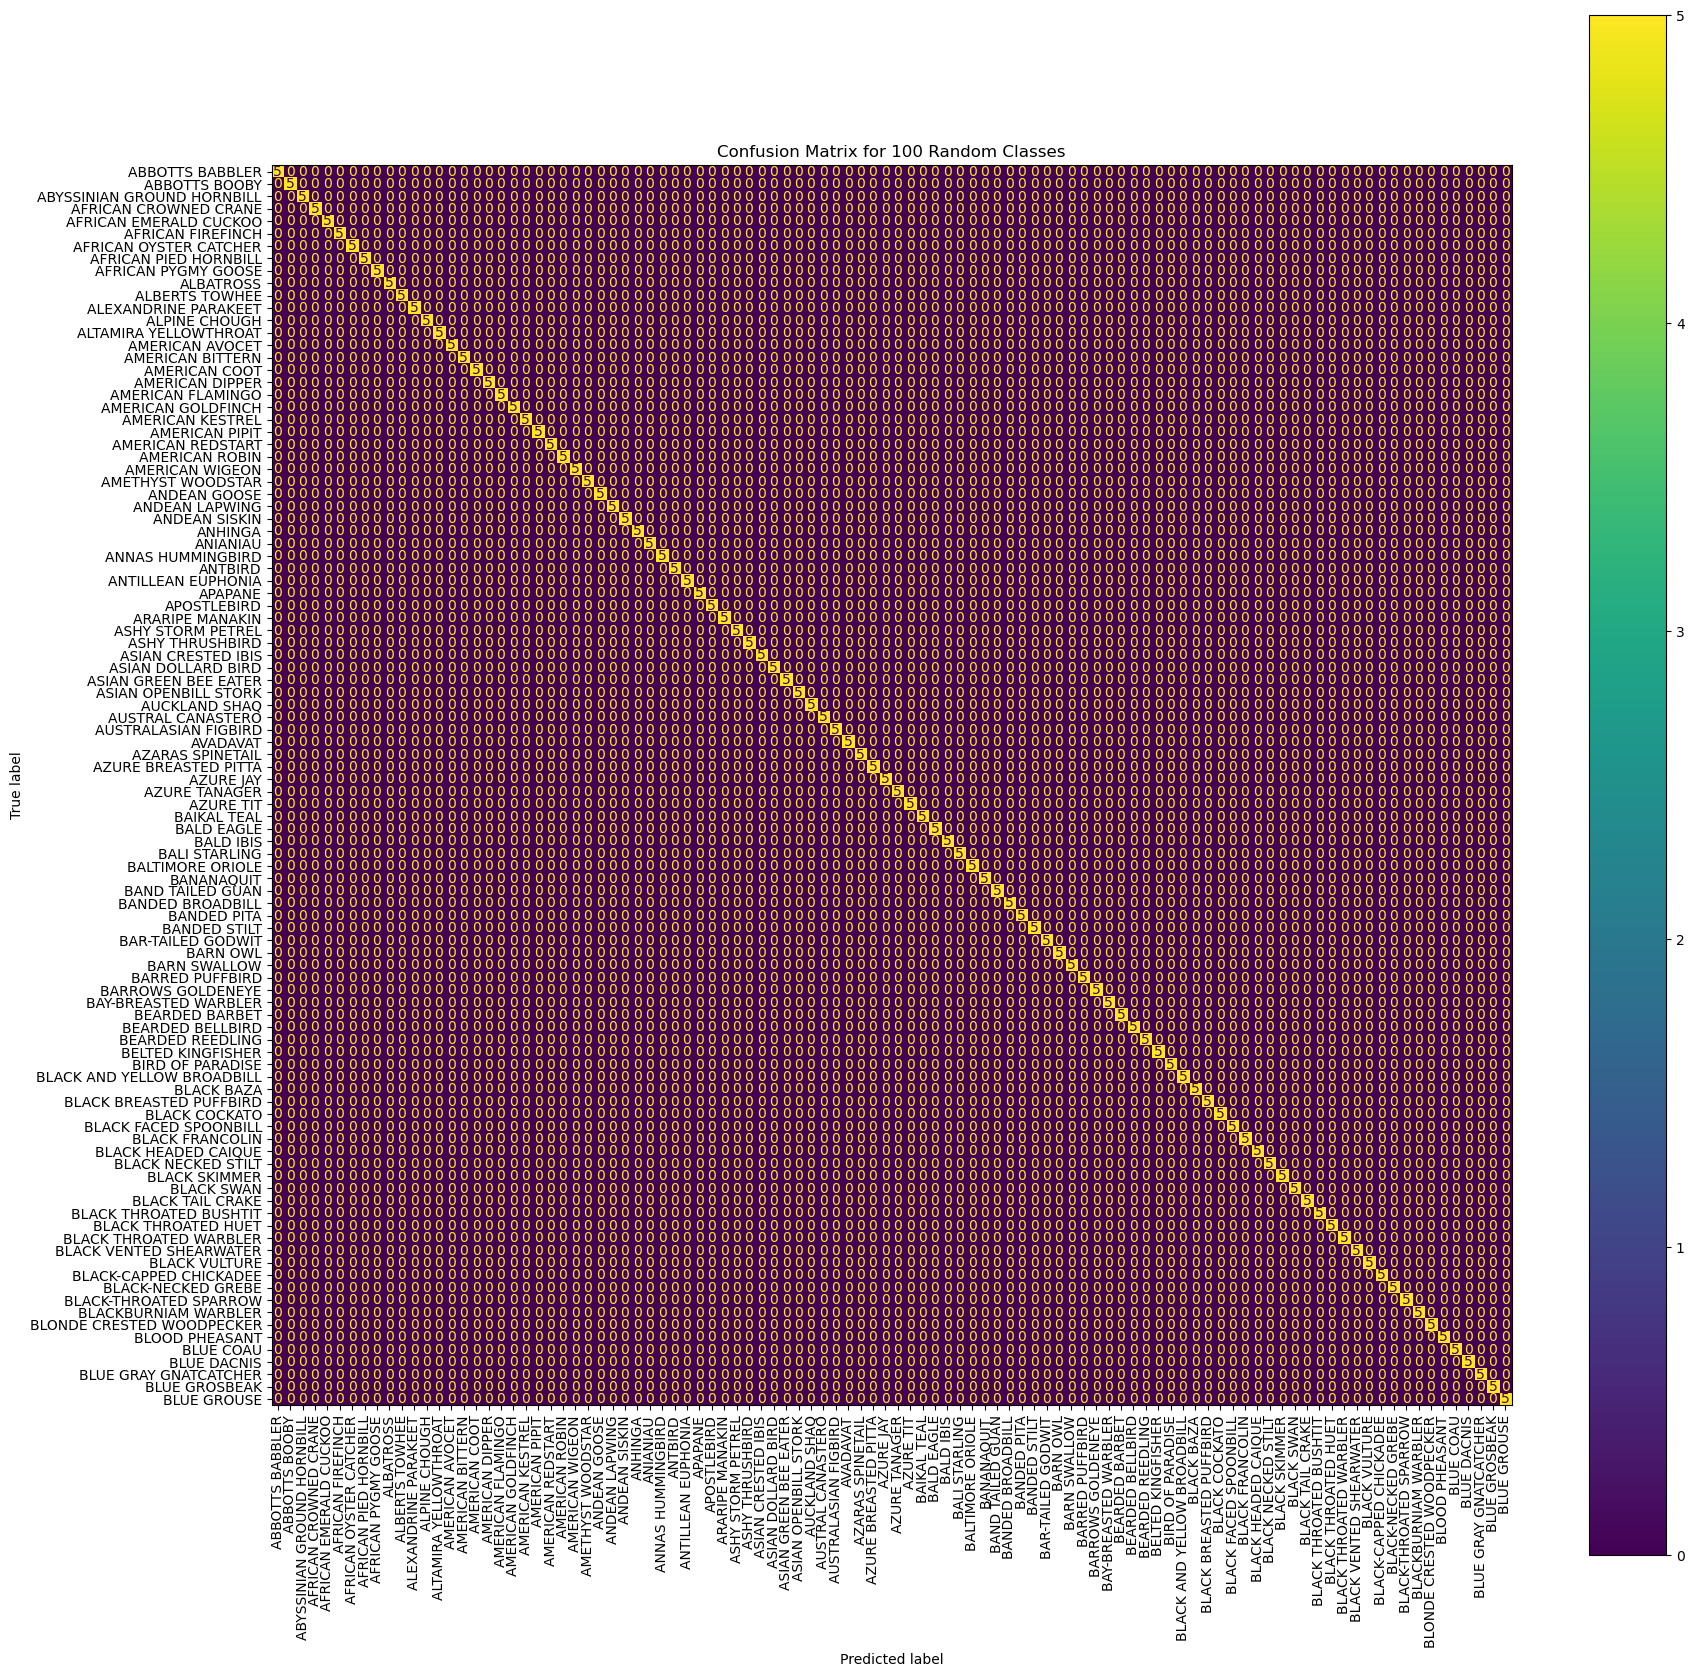

In [15]:
# Use the function to plot the confusion matrix for a random selection of X classes
plot_confusion_matrix(arc_network, ds_test, class_names, num_classes=100)

- function below uncommented (Not applicable as method got 100% accuracy)

In [17]:
# def find_poorest_performing_classes(report, top_n=10):
#     class_accuracies = {class_name: report[class_name]['recall'] for class_name in report.keys() if class_name not in ['accuracy', 'macro avg', 'weighted avg']}
#     poorest_classes = sorted(class_accuracies.items(), key=lambda x: x[1])[:top_n]
#     poorest_classes_names = [item[0] for item in poorest_classes]
#     poorest_classes_accuracies = [item[1] for item in poorest_classes]
#     return poorest_classes_names, poorest_classes_accuracies

# def plot_poor_performing_classes(model, test_dataset, poorest_classes_names, poorest_classes_accuracies, class_names, top_n=10):
#     fig, axes = plt.subplots(top_n, 5, figsize=(20, 4 * top_n))  # Adjust the figure height to accommodate text
#     class_indices = [class_names.index(name) for name in poorest_classes_names]
    
#     for i, class_idx in enumerate(class_indices):
#         class_images = []
#         for images, labels in test_dataset.unbatch():
#             if labels.numpy() == class_idx:
#                 class_images.append(images.numpy())
#             if len(class_images) == 5:
#                 break

#         for j in range(5):
#             axes[i, j].imshow(class_images[j].astype('uint8'))
#             axes[i, j].axis('off')

#         # Add class name and accuracy to the right of the row
#         axes[i, -1].text(1.1, 0.5, f"{poorest_classes_names[i]}\nAccuracy: {poorest_classes_accuracies[i]:.2f}",
#                          transform=axes[i, -1].transAxes, ha='left', va='center', fontsize=12)

#     plt.tight_layout(rect=[0, 0, 0.95, 0.97])
#     plt.show()
    
# poorest_classes_names, poorest_classes_accuracies = find_poorest_performing_classes(report, top_n=10)
# plot_poor_performing_classes(arc_network, ds_test, poorest_classes_names, poorest_classes_accuracies, class_names, top_n=10)